In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xone import calendar

plt.style.use('ggplot')

In [36]:
################################################################
##-----Importing the dataset
##-----The ETF is **iShares Russell 2000 ETF (IWM)**, data downloaded from Yahoo Finance
##-----https://finance.yahoo.com/quote/IWM/history?period1=1447891200&period2=1625011200&interval=1d&filter=history&frequency=1d&##-----includeAdjustedClose=true
file_sample = 'D:/millennium_data_exercise/Sample_Dataset.xlsx'
file_data_yahoo = 'D:/millennium_data_exercise/IWM.csv'

df_s = pd.read_excel(file_sample).set_index('Date')
df_r = pd.read_csv(file_data_yahoo).set_index('Date')

## Part I: Identifying the Abnormal Data

In [37]:
df_s['Signal Filled'],df_s['Open Filled'],df_s['High Filled'],df_s['Low Filled'],df_s['Close Filled'],df_s['Adj Close Filled'] = False,False,False,False,False,False
df_s

,Signal,Open,High,Low,Close,Adj Close,Signal Filled,Open Filled,High Filled,Low Filled,Close Filled,Adj Close Filled
Date,,,,,,,,,,,,
2015-11-19,13.768540,116.440002,116.650002,115.739998,116.059998,108.281601,False,False,False,False,False,False
2015-11-20,13.608819,116.480003,117.360001,116.379997,116.809998,108.981323,False,False,False,False,False,False
2015-11-23,12.990589,116.709999,117.889999,116.680000,117.389999,109.522453,False,False,False,False,False,False
2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837,False,False,False,False,False,False
2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30,0.000000,165.979996,166.210007,164.570007,165.440002,163.623688,False,False,False,False,False,False
2019-12-31,0.000000,165.080002,166.350006,164.710007,165.669998,163.851135,False,False,False,False,False,False
2020-01-02,0.000000,166.740005,166.750000,164.229996,165.779999,163.959946,False,False,False,False,False,False


In [38]:
####################################################################
##----Dealing with the date column
##----You can find 2018-12-05 is not even included in the xone package, but news tells that the US stock markets were actually ##----closed in memory of president Bush's death.
def business_dates(start, end):
    us_cal = calendar.USTradingCalendar()
    kw = dict(start=start, end=end)
    return pd.bdate_range(**kw).drop(us_cal.holidays(**kw))

b_day = pd.Series(business_dates(start='2015-11-19',end='2020-01-06'))  ######### b_day i s the trading days in US
sample_day = pd.to_datetime(df_s.index)
yahoo_day = pd.to_datetime(df_r.index)

df_s['is new'] = False

print(set(sample_day)-set(b_day))

for ele in set(sample_day)-set(b_day):
    df_s = df_s[pd.to_datetime(df_s.index) != ele]

df_s = df_s.append(pd.DataFrame(index = list(set(yahoo_day)-set(sample_day))))
df_s.sort_index(inplace = True)

df_s.loc[df_s['is new'].isnull(), 'is new'] = True

for col in ['Signal Filled', 'Open Filled', 'High Filled', 'Low Filled', 'Close Filled', 'Adj Close Filled']:
    df_s.loc[df_s['is new'], col] = True

#print((pd.to_datetime(df_s.index) == pd.to_datetime(df_r.index)).all())
df_s[df_s['Signal Filled']]

{Timestamp('2018-06-23 00:00:00'), Timestamp('2018-05-19 00:00:00'), Timestamp('2018-05-20 00:00:00'), Timestamp('2017-07-04 00:00:00'), Timestamp('2018-06-24 00:00:00')}


,Signal,Open,High,Low,Close,Adj Close,Signal Filled,Open Filled,High Filled,Low Filled,Close Filled,Adj Close Filled,is new
2018-11-12,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,True,True
2018-11-13,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,True,True
2018-11-14,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,True,True
2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,True,True
2018-11-16,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,True,True


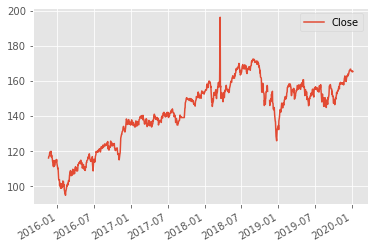

In [39]:
df_s.plot(y = ['Close'])

In [40]:
####################################################################
##----Detecting and filling the outliers

##----Define a function to detect the outliers using rolling median
def detect_otl(pd_series, windows_lgth):
    rolling_med = pd_series.rolling(windows_lgth).median()
    rolling_std = pd_series.rolling(windows_lgth).std()

    return (pd_series > rolling_med + 3 * rolling_std) | (pd_series < rolling_med - 3 * rolling_std)

##---- Define the interpolation funciton in the log scheme
def log_interp(pd_series):
    temp_log = np.log(pd_series)
    temp_interp = pd.Series(temp_log).interpolate()
    return pd.Series(np.exp(temp_interp))

##---- For the detection and filling of the outliers
df_s.loc[df_s['Signal']<0.001, 'Signal'] = np.nan
for col in ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']:
    df_s.loc[detect_otl(df_s[col], 11), col] = np.nan

for col in ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']:
    df_s.loc[df_s[col].isnull(), col+' Filled'] = True

df_s[df_s['Signal Filled'] | df_s['Open Filled'] | df_s['High Filled'] | df_s['Low Filled'] | df_s['Close Filled'] | df_s['Adj Close Filled']]

#df_s['Signal'] = df_s['Signal'].fillna(df_s['Signal'].rolling(11, min_periods=1).mean())

#for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
#    df_s[col] = log_interp(df_s[col])

#df_s['Signal'].plot()

,Signal,Open,High,Low,Close,Adj Close,Signal Filled,Open Filled,High Filled,Low Filled,Close Filled,Adj Close Filled,is new
2016-07-13,NaN,120.330002,120.389999,118.949997,119.250000,112.691780,True,False,False,False,False,False,False
2016-11-30,NaN,132.919998,133.089996,131.500000,131.610001,124.715752,True,False,False,False,False,False,False
2016-12-05,16.011011,131.970001,133.330002,131.889999,133.149994,NaN,False,False,False,False,False,True,False
2017-03-22,NaN,133.710007,134.309998,132.779999,134.000000,127.504295,True,False,False,False,False,False,False
2017-03-27,16.032241,132.759995,135.070007,132.399994,134.740005,NaN,False,False,False,False,False,True,False
2017-05-17,15.682386,136.330002,137.039993,NaN,134.889999,128.720795,False,False,False,True,False,False,False
2017-09-25,17.042562,144.270004,144.940002,143.690002,NaN,NaN,False,False,False,False,True,True,False
2017-11-13,NaN,145.929993,146.820007,145.500000,146.610001,140.849274,True,False,False,False,False,False,False
2018-02-05,16.662260,152.669998,153.789993,NaN,NaN,NaN,False,False,False,True,True,True,False
2018-03-19,18.660897,157.169998,157.210007,154.449997,NaN,150.708221,False,False,False,False,True,False,False


In [41]:
####################################################################
##----Filtering out the rows that are inconsistent, i.e., row['High'] not being the highest or row['Low'] not being the lowest
for row in df_s.index:
    df_s.loc[row, 'True High'] = (df_s.loc[row, 'High'] == max(df_s.loc[row,'Open'], df_s.loc[row, 'High'], df_s.loc[row, 'Low'], df_s.loc[row, 'Close']))
    df_s.loc[row, 'True Low'] = (df_s.loc[row, 'Low'] == min(df_s.loc[row,'Open'], df_s.loc[row, 'High'], df_s.loc[row, 'Low'], df_s.loc[row, 'Close']))

df_s.loc[~(df_s['True High'] & df_s['True Low']), ['Open', 'High', 'Low', 'Close', 'Adj Close']]  = np.nan
df_s.loc[~(df_s['True High'] & df_s['True Low']), ['Open Filled', 'High Filled', 'Low Filled', 'Close Filled', 'Adj Close Filled']]  = True

for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
    df_s[col] = log_interp(df_s[col])
    
df_s[~(df_s['True High'] & df_s['True Low'])]

,Signal,Open,High,Low,Close,Adj Close,Signal Filled,Open Filled,High Filled,Low Filled,Close Filled,Adj Close Filled,is new,True High,True Low
2017-05-17,15.682386,136.752309,137.461028,135.914427,136.995368,130.729840,False,True,True,True,True,True,False,True,False
2017-08-07,16.298805,140.159781,141.053085,139.589968,140.104964,134.274750,False,True,True,True,True,True,False,False,True
2017-09-11,15.838558,139.407169,140.232283,139.073416,139.560233,133.779650,False,True,True,True,True,True,False,True,False
2017-09-12,15.518587,139.885984,140.696090,139.528320,140.011922,134.239679,False,True,True,True,True,True,False,True,False
2017-09-13,16.158529,140.366443,141.161432,139.984712,140.465072,134.701289,False,True,True,True,True,True,False,True,False
2017-09-14,16.478500,140.848553,141.628313,140.442597,140.919690,135.164487,False,True,True,True,True,True,False,True,False
2017-09-15,15.198617,141.332318,142.096738,140.901979,141.375779,135.629277,False,True,True,True,True,True,False,True,False
2017-09-18,15.518587,141.817745,142.566712,141.362864,141.833344,136.095666,False,True,True,True,True,True,False,True,False
2017-09-19,16.798471,142.304839,143.038240,141.825257,142.292390,136.563659,False,True,True,True,True,True,False,True,False
2017-09-20,15.953688,142.793607,143.511329,142.289162,142.752921,137.033261,False,True,True,True,True,True,False,True,False


In [42]:
####################################################################
##----To check how the filled sample form is compared with the downloaded data, check critical value is 1%
df_s['Open Check'], df_s['High Check'], df_s['Low Check'], df_s['Close Check'] = True, True, True, True
for col in ['Open', 'High', 'Low', 'Close']:
    df_s[col + ' Check'] =- (df_s[col]>1.01*df_r[col]) | (df_s[col]<0.99*df_r[col])
df_s[~df_s['Close Check']]

,Signal,Open,High,Low,Close,Adj Close,Signal Filled,Open Filled,High Filled,Low Filled,Close Filled,Adj Close Filled,is new,True High,True Low,Open Check,High Check,Low Check,Close Check
2017-05-17,15.682386,136.752309,137.461028,135.914427,136.995368,130.729840,False,True,True,True,True,True,False,True,False,True,True,True,False
2018-02-05,16.662260,150.736855,153.232744,148.802831,151.745884,146.335773,False,True,True,True,True,True,False,True,False,True,True,True,False
2018-11-12,NaN,155.271548,155.356098,152.176961,153.197460,149.007274,True,True,True,True,True,True,True,False,False,True,True,True,False
2018-11-13,NaN,154.546497,154.685107,151.407833,152.319974,148.153789,True,True,True,True,True,True,True,False,False,False,False,True,False
2018-11-14,NaN,153.824832,154.017014,150.642591,151.447513,147.305191,True,True,True,True,True,True,True,False,False,False,False,False,False
2019-09-24,18.630976,153.564582,155.152962,153.173784,154.703819,152.178884,False,True,True,True,True,True,False,True,False,True,True,True,False
